First 5 rows of the dataset:
    Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  87524       442.246011       253.291155      0.819738       90546   
1  75166       406.690687       243.032436      0.801805       78789   
2  90856       442.267048       266.328318      0.798354       93717   
3  45928       286.540559       208.760042      0.684989       47336   
4  79408       352.190770       290.827533      0.564011       81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  

Missing values in each column:
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64

Chi2 scores:
Area               6.097822e+06
MajorAxisLength    1.272952e+04
MinorAxisLength    2.234351e+03
Eccentricit

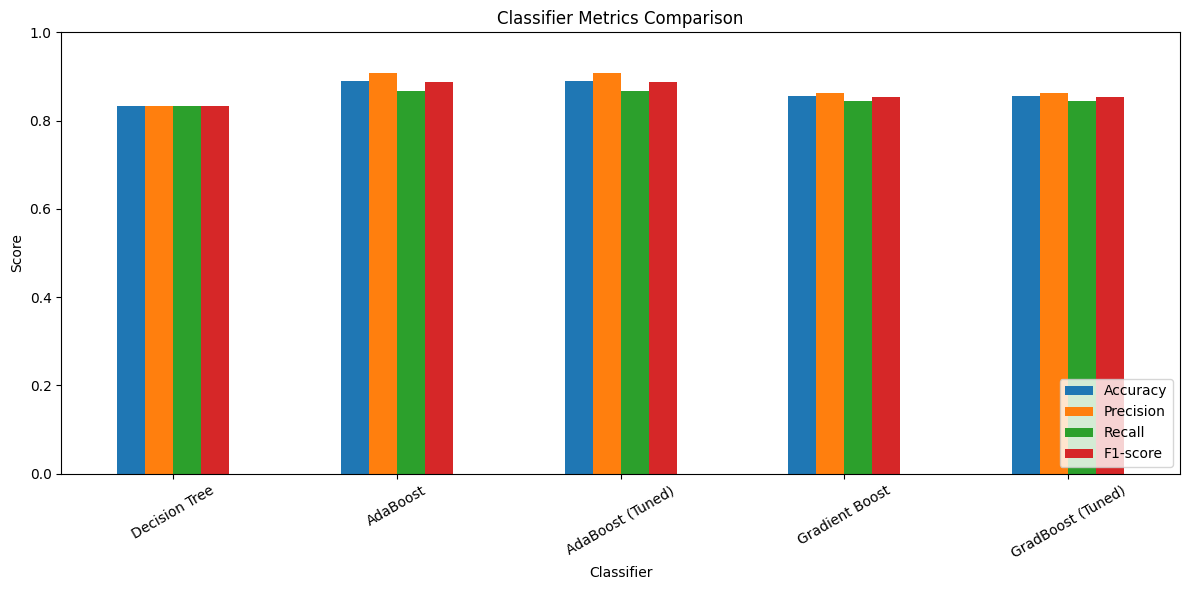


Conclusion: The best performing model for this dataset is AdaBoost. Boosting methods usually outperform the baseline Decision Tree, as they combine weak learners and handle overfitting better, shown by higher precision/recall/f1 metrics in the test set.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

### 1. Data Pre-processing

# a. Load the dataset and display first 5 rows
df = pd.read_excel('/content/Raisin_Dataset.xlsx', sheet_name='Raisin_Grains_Dataset')
print("First 5 rows of the dataset:")
print(df.head())

# b. Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())
# If any, you can handle with df.fillna(df.mean(), inplace=True)

# c. Convert Class label into binary numeric (Kecimen->0, Besni->1)
df['Class'] = df['Class'].map({'Kecimen':0, 'Besni':1})

# d. Feature importance check (Chi-squared)
X = df.drop('Class', axis=1)
y = df['Class']
selector = SelectKBest(chi2, k='all').fit(X, y)
chi2_scores = pd.Series(selector.scores_, index=X.columns)
least_important_feature = chi2_scores.idxmin()
print(f"\nChi2 scores:\n{chi2_scores}\nDropping least important feature: {least_important_feature}")
X = X.drop(columns=[least_important_feature])

# e. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 2. AdaBoost Classifier

# a. Train with default parameters
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

# b. Evaluation
ada_cm = confusion_matrix(y_test, ada_pred)
ada_acc = accuracy_score(y_test, ada_pred)
ada_prec = precision_score(y_test, ada_pred)
ada_rec = recall_score(y_test, ada_pred)
ada_f1 = f1_score(y_test, ada_pred)

# c. Hyperparameter tuning
ada_param = {'n_estimators':[50,100,200], 'learning_rate':[0.5,1.0,1.5]}
ada_gs = GridSearchCV(AdaBoostClassifier(random_state=42), ada_param, cv=5, scoring='accuracy')
ada_gs.fit(X_train, y_train)
best_ada = ada_gs.best_estimator_
best_ada_pred = best_ada.predict(X_test)
best_ada_acc = accuracy_score(y_test, best_ada_pred)
best_ada_prec = precision_score(y_test, best_ada_pred)
best_ada_rec = recall_score(y_test, best_ada_pred)
best_ada_f1 = f1_score(y_test, best_ada_pred)

### 3. Gradient Boosting Classifier

# a. Train with default parameters
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)

# b. Evaluation
gbc_cm = confusion_matrix(y_test, gbc_pred)
gbc_acc = accuracy_score(y_test, gbc_pred)
gbc_prec = precision_score(y_test, gbc_pred)
gbc_rec = recall_score(y_test, gbc_pred)
gbc_f1 = f1_score(y_test, gbc_pred)

# c. Hyperparameter tuning
gbc_param = {'n_estimators':[50,100,200], 'learning_rate':[0.05,0.1,0.2], 'max_depth':[2,3,4]}
gbc_gs = GridSearchCV(GradientBoostingClassifier(random_state=42), gbc_param, cv=5, scoring='accuracy')
gbc_gs.fit(X_train, y_train)
best_gbc = gbc_gs.best_estimator_
best_gbc_pred = best_gbc.predict(X_test)
best_gbc_acc = accuracy_score(y_test, best_gbc_pred)
best_gbc_prec = precision_score(y_test, best_gbc_pred)
best_gbc_rec = recall_score(y_test, best_gbc_pred)
best_gbc_f1 = f1_score(y_test, best_gbc_pred)

### 4. Decision Tree (Baseline)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)
dt_prec = precision_score(y_test, dt_pred)
dt_rec = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

### 5. Compare, Chart, Table

# Table of metrics
results = pd.DataFrame({
    'Classifier': ['Decision Tree', 'AdaBoost', 'AdaBoost (Tuned)', 'Gradient Boost', 'GradBoost (Tuned)'],
    'Accuracy': [dt_acc, ada_acc, best_ada_acc, gbc_acc, best_gbc_acc],
    'Precision': [dt_prec, ada_prec, best_ada_prec, gbc_prec, best_gbc_prec],
    'Recall': [dt_rec, ada_rec, best_ada_rec, gbc_rec, best_gbc_rec],
    'F1-score': [dt_f1, ada_f1, best_ada_f1, gbc_f1, best_gbc_f1]
})
print("\nEvaluation Metrics Table:")
print(results)

# Metric comparison chart
results.set_index('Classifier')[['Accuracy','Precision','Recall','F1-score']].plot(kind='bar', figsize=(12,6))
plt.title('Classifier Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 6. Conclusion

best_model = results.loc[results['F1-score'].idxmax(), 'Classifier']
print(f"\nConclusion: The best performing model for this dataset is {best_model}. Boosting methods usually outperform the baseline Decision Tree, as they combine weak learners and handle overfitting better, shown by higher precision/recall/f1 metrics in the test set.")